# Useful packages

In [1]:
import matplotlib.pyplot as plt

# Loading Steinmetz SPIKING data

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [3]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Loading Steinmetz LFP data

In [ ]:
#@title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading
import numpy as np

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = dat_LFP[11]
print(dat.keys())
dat = dat_WAV[11]
print(dat.keys())
dat = dat_ST[11]
print(dat.keys())

`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




# Wheel data analysis (Tomáš)

In [5]:
#@title Wheel data extraction
def extract_wheel_data(session, trial):
  """ Extracts the wheel speed and calculates the wheel position at each time bin. Requires the SPIKING dataset to be loaded.

  Args:
    session (int): For which session to extract the wheel data.
    trial (int): For which trial to extract the wheel data.
  
  Return:
    wheel_pos: A vector of positions sampled in 10 ms bins
    wheel_speed: A vector of speeds sampled in 10 ms bins
  """

  wheel_speed = alldat[session]['wheel'][0][trial]
  
  wheel_pos = np.zeros(len(wheel_speed))
  for t in range(1,len(wheel_speed)):
    wheel_pos[t] = wheel_pos[t-1] + wheel_speed[t]

  return wheel_pos, wheel_speed

In [12]:
#@title Stimulus data extraction
def extract_stim_data(session):
  """ Extracts the stimulus information about each trial. Requires the SPIKING dataset to be loaded.

  Args:
    session (int): For which session to extract the stimulus data
    trial (int): For which trial to extract the stimulus data
  
  Return:
    stim_bilateral (bool): A vector of booleans saying whether BOTH stimuli were presented (True) or just one (False)
    stim_right (bool): A vector of booleans saying whether the RIGHT stimulus was presented (True)
    stim_left (bool): A vector of booleans saying whether the LEFT stimulus was presented (True)
    stim_diff (float): A vector of differences between the two stimuli contrasts; None means that only one stimulus was presented; positive values mean larger contrast in the right stimulus
  """

  right_contrast = alldat[session]['contrast_right']
  left_contrast = alldat[session]['contrast_left']

  stim_nostim = (right_contrast + left_contrast) == 0
  stim_bilateral = np.minimum(right_contrast, left_contrast) > 0
  stim_right = right_contrast > 0
  stim_left = left_contrast > 0
  stim_diff = right_contrast - left_contrast


  return stim_nostim, stim_bilateral, stim_right, stim_left, stim_diff

In [7]:
#@title Set your session here
session = 0

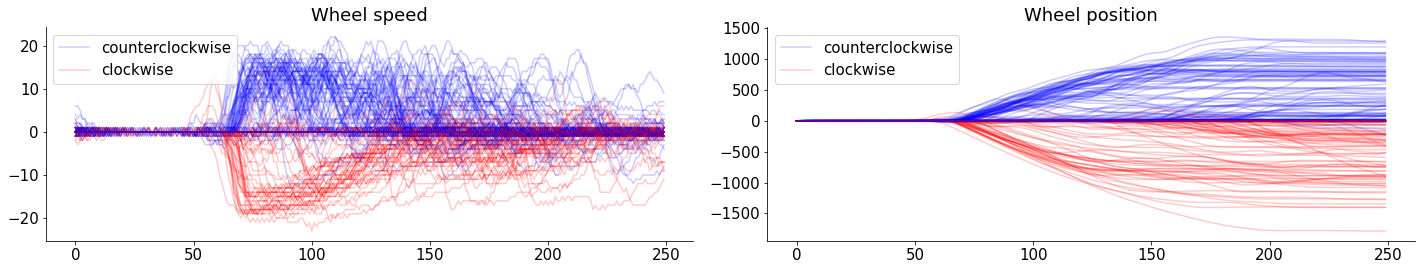

In [8]:
#@title Sample wheel data visualization
n_trials = len(alldat[session]['wheel'][0])

plot, (ax1, ax2) = plt.subplots(1,2, sharey=False)

for trial in range(n_trials):
  wheel_pos, wheel_speed = extract_wheel_data(session,trial)
  if np.mean(wheel_pos) > 0:
    color = 'blue'
  else:
    color = 'red'
  ax1.plot(wheel_speed, color, alpha = 0.2)
  ax2.plot(wheel_pos, color, alpha = 0.2)

ax1.title.set_text('Wheel speed')
ax2.title.set_text('Wheel position')
ax1.legend(['counterclockwise','clockwise'], loc = 2)
ax2.legend(['counterclockwise','clockwise'], loc = 2)

Text(0, 0.5, 'No stimulus')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


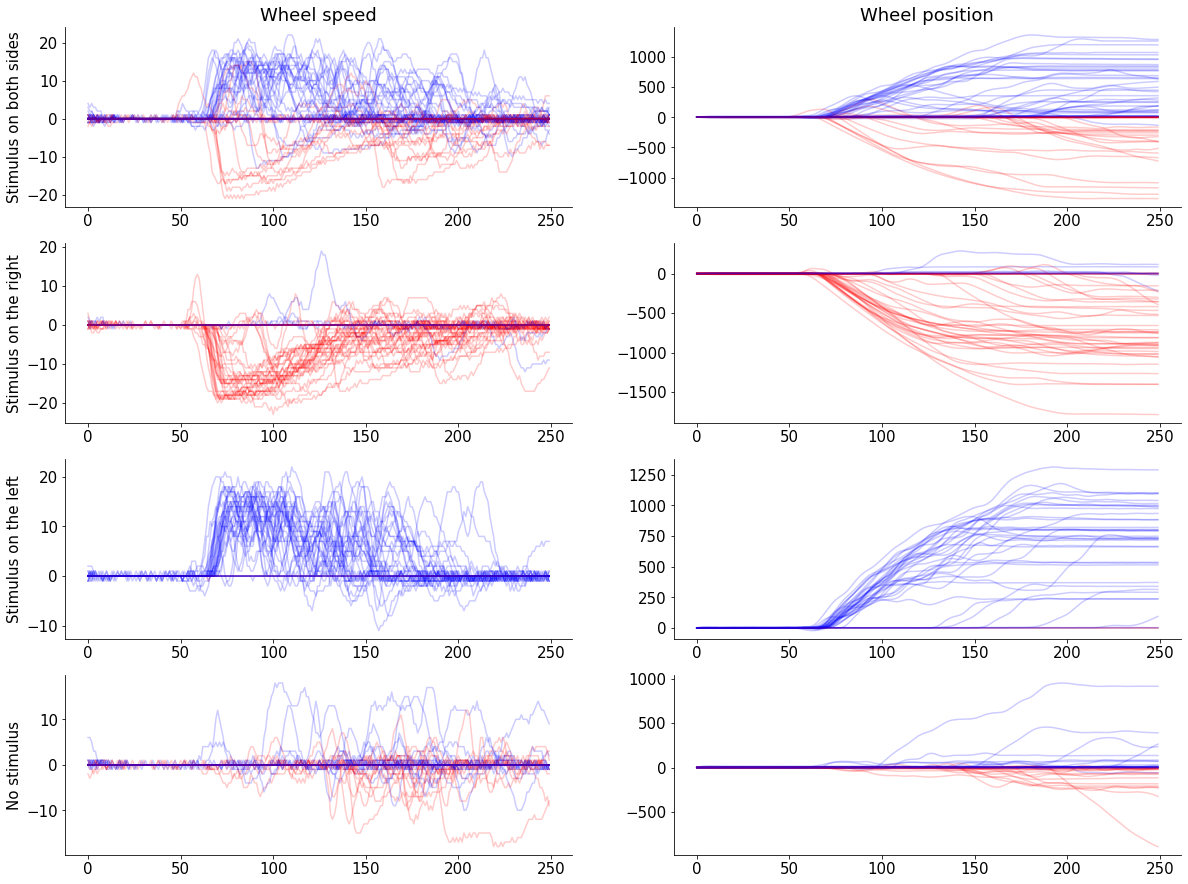

In [11]:
#@title Wheel data with respect to presence of visual stimuli
n_trials = len(alldat[session]['wheel'][0])

plot, ((ax1_1, ax1_2), (ax2_1, ax2_2), (ax3_1, ax3_2), (ax4_1, ax4_2)) = plt.subplots(nrows = 4, ncols = 2, sharey=False, gridspec_kw={'top': 3})

stim_nostim, stim_bilateral, stim_right, stim_left, stim_diff = extract_stim_data(session)

for trial in range(n_trials):
  wheel_pos, wheel_speed = extract_wheel_data(session,trial)
  color = 'blue' if np.mean(wheel_pos) > 0 else 'red'

  if stim_bilateral[trial] == True:
    ax1_1.plot(wheel_speed, color, alpha = 0.2)
    ax1_2.plot(wheel_pos, color, alpha = 0.2)
  elif stim_right[trial] == True:
    ax2_1.plot(wheel_speed, color, alpha = 0.2)
    ax2_2.plot(wheel_pos, color, alpha = 0.2)
  elif stim_left[trial] == True:
    ax3_1.plot(wheel_speed, color, alpha = 0.2)
    ax3_2.plot(wheel_pos, color, alpha = 0.2)
  elif stim_nostim[trial] == True:
    ax4_1.plot(wheel_speed, color, alpha = 0.2)
    ax4_2.plot(wheel_pos, color, alpha = 0.2)

ax1_1.set_title('Wheel speed')
ax1_2.set_title('Wheel position')
ax1_1.set_ylabel('Stimulus on both sides')
ax2_1.set_ylabel('Stimulus on the right')
ax3_1.set_ylabel('Stimulus on the left')
ax4_1.set_ylabel('No stimulus')

Text(0, 0.5, '75% contrast difference')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


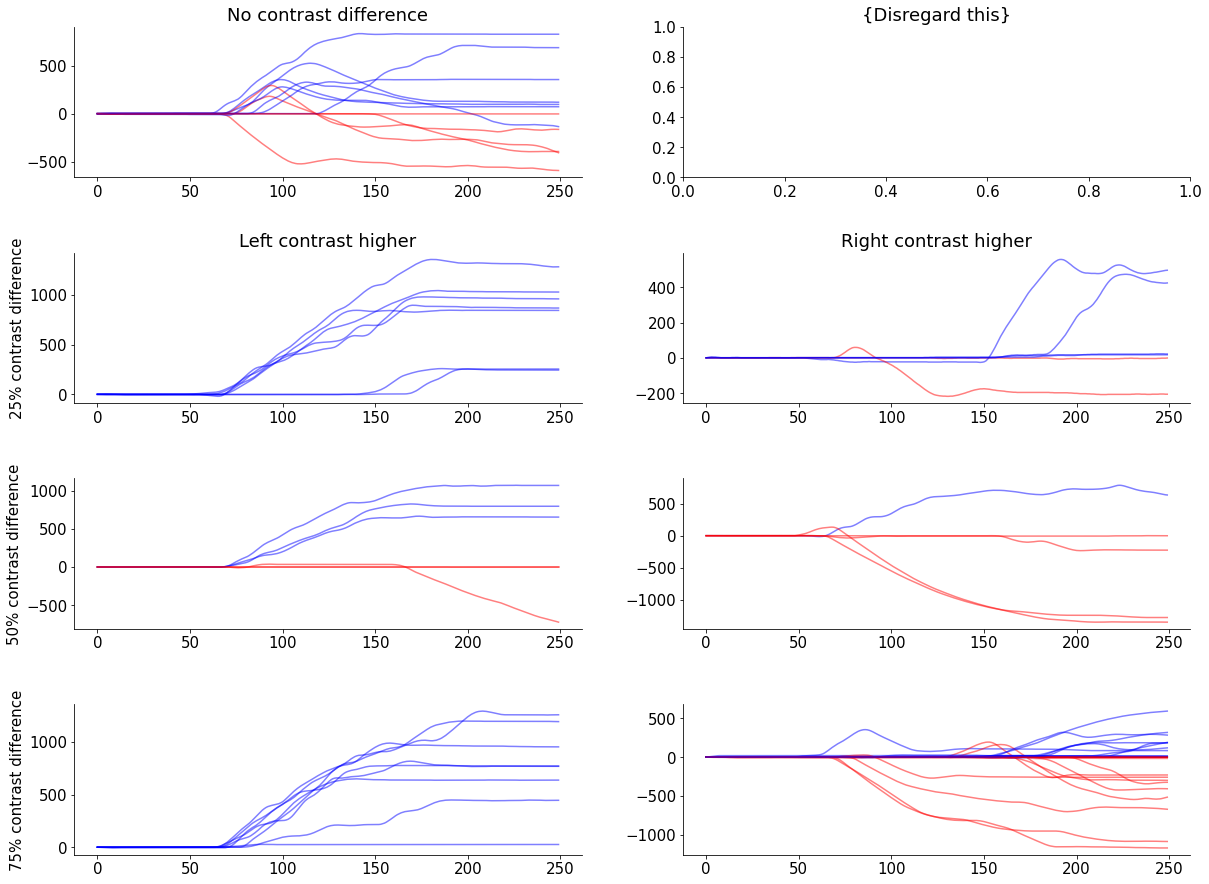

In [14]:
#@title Wheel data with respect to contrast differences (for bilateral stimuli only)

n_trials = len(alldat[session]['wheel'][0])

plot, ((ax1_1, ax1_2), (ax2_1, ax2_2), (ax3_1, ax3_2), (ax4_1, ax4_2)) = plt.subplots(nrows = 4, ncols = 2, sharey=False, gridspec_kw={'top': 3, 'hspace': 0.5})

stim_nostim, stim_bilateral, stim_right, stim_left, stim_diff = extract_stim_data(session)

for trial in range(n_trials):
  if stim_bilateral[trial] == False: continue 

  wheel_pos, wheel_speed = extract_wheel_data(session,trial)
  color = 'blue' if np.mean(wheel_pos) > 0 else 'red'
  alpha = 0.5

  if stim_diff[trial] == 0:
    ax1_1.plot(wheel_pos, color, alpha = alpha)
  elif stim_diff[trial] == -0.25:
    ax2_1.plot(wheel_pos, color, alpha = alpha)
  elif stim_diff[trial] == 0.25:
    ax2_2.plot(wheel_pos, color, alpha = alpha)
  elif stim_diff[trial] == -0.50:
    ax3_1.plot(wheel_pos, color, alpha = alpha)
  elif stim_diff[trial] == 0.50:
    ax3_2.plot(wheel_pos, color, alpha = alpha)
  elif stim_diff[trial] == -0.75:
    ax4_1.plot(wheel_pos, color, alpha = alpha)
  elif stim_diff[trial] == 0.75:
    ax4_2.plot(wheel_pos, color, alpha = alpha)

ax1_1.set_title('No contrast difference')
ax1_2.set_title('{Disregard this}')
ax2_1.set_title('Left contrast higher')
ax2_2.set_title('Right contrast higher')
ax2_1.set_ylabel('25% contrast difference')
ax3_1.set_ylabel('50% contrast difference')
ax4_1.set_ylabel('75% contrast difference')